In [59]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.layers import Bidirectional, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split 
from tensorflow.keras.callbacks import EarlyStopping

# Download necessary NLTK resources
nltk.download('punkt')      # Tokenizers for strings
nltk.download('wordnet')    # Lexical database for the English language
nltk.download('stopwords')  # Stopwords for filtering out unnecessary words

# Ensure TensorFlow is imported if needed later in the script (you can remove this if not using TensorFlow functions directly)
import tensorflow as tf


[nltk_data] Downloading package punkt to
[nltk_data]     /home/UG/kanupriy001/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/UG/kanupriy001/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/UG/kanupriy001/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
import nltk
# Downloading the stopwords collection from NLTK to filter out in our text processing
nltk.download('stopwords')
MAX_SEQUENCE_LENGTH=20
EMBEDDING_DIM=50

stop_words = set(stopwords.words('english')) 
new_stop_words=set(stop_words)



dataFrame=pd.read_csv('Preprocessed Data.csv', encoding='utf-8')

x=dataFrame.values[:,3]
y=dataFrame.values[:,1]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/UG/kanupriy001/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
x,y

(array(['anger', 'anger', 'anger', ..., 'love', 'joy', 'love'],
       dtype=object),
 array([0, 1, 2, ..., 43957, 43958, 43959], dtype=object))

In [62]:
dataFrame.head()

,Unnamed: 0,index,tweet,tweettype,tweettype2,charCount,wordCount,sentenceCount,capCharCount,capWordCount,...,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count,lemmatizedText
0,0,0,@ZubairSabirPTI pls dont insult the word 'Molna',anger,negative,49,7,1,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pls dont insult word
1,1,1,@ArcticFantasy I would have almost took offens...,anger,negative,81,14,1,4,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,would almost take offense actually snap
2,2,2,@IllinoisLoyalty that Rutgers game was an abom...,anger,negative,114,20,3,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rutgers game abomination affront god man must ...
3,3,3,@CozanGaming that's what lisa asked before she...,anger,negative,90,16,2,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,lisa ask start rag call heh
4,4,4,Sometimes I get mad over something so minuscul...,anger,negative,133,25,1,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sometimes get mad something minuscule try ruin...


In [63]:
dataFrame.columns

Index(['Unnamed: 0', 'index', 'tweet', 'tweettype', 'tweettype2', 'charCount',
       'wordCount', 'sentenceCount', 'capCharCount', 'capWordCount',
       'quotedWordCount', 'stopwordCount', 'uniqueWordCount', 'hashCount',
       'mentionCount', 'avgWordLen', 'modTweet', '! count', '" count',
       '# count', '$ count', '% count', '& count', '' count', '( count',
       ') count', '* count', '+ count', ', count', '- count', '. count',
       '/ count', ': count', '; count', '< count', '= count', '> count',
       '? count', '@ count', '[ count', '\ count', '] count', '^ count',
       '_ count', '` count', '{ count', '| count', '} count', '~ count',
       'lemmatizedText'],
      dtype='object')

In [64]:
x_data=list(dataFrame['lemmatizedText'])


### Preprocessing Pipeline

For preprocessing, text data from tweets is cleaned, tokenized, and converted into a format suitable for training a machine learning model. It includes handling missing values by assigning 'neutral' to NaN entries in the 'tweettype2' column, encoding sentiment labels ('negative', 'neutral', 'positive') into numerical format and then into one-hot vectors for model training. The feature engineering function standardizes the text by converting it to lowercase, removing URLs, stock symbols, usernames, non-alphabetical characters, and single-letter words. After cleaning, each tweet is lemmatized to reduce words to their base or dictionary form. The Tokenizer then converts the text into sequences of integers, which are padded to a uniform length. 

In [65]:
import tensorflow as tf
import re

# Treating NaN as 'neutral'
labels_with_neutral = dataFrame['tweettype2'].fillna('neutral')

labels = labels_with_neutral.values

# Initialize the list for encoded labels
y = []
for label in labels:
    if label == 'negative':
        y.append(0)
    elif label == 'neutral':
        y.append(1)
    elif label == 'positive':
        y.append(2)

# Convert the list to a numpy array
y = np.array(y)

labels = tf.keras.utils.to_categorical(y, num_classes=3, dtype="float32") 
del y


def featureEngineering(tweet):
    # Lower case tweet
    tweetMod = tweet.lower()
    # Replace URLs with a space in the message
    tweetMod = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', tweetMod)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    tweetMod = re.sub('\$[a-zA-Z0-9]*', ' ', tweetMod)
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    tweetMod = re.sub('\@[a-zA-Z0-9]*', ' ', tweetMod)
    # Replace everything not a letter or apostrophe with a space
    tweetMod = re.sub('[^a-zA-Z\']', ' ', tweetMod)
    # Remove single letter words
    tweetMod = ' '.join([w for w in tweetMod.split() if len(w) > 1])

    return tweetMod

tweetData=dataFrame

# Process for all tweets
tweetData['modTweet'] = [featureEngineering(tweet) for tweet in tweetData['tweet']]

def lemmatizeTweet(tweet):
  words = [word for word in word_tokenize(tweet) if (word.isalpha()==1)]
  # Remove stop words
  stop = set(stopwords.words('english'))
  words = [word for word in words if (word not in stop)]
  # Lemmatize words (first noun, then verb)
  wnl = nltk.stem.WordNetLemmatizer()
  lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
  return " ".join(lemmatized)

tweetData['lemmatizedText'] = tweetData["modTweet"].apply(lambda x:lemmatizeTweet(x))

tokenizer = Tokenizer(num_words=27608, split=' ')
tokenizer.fit_on_texts(tweetData['lemmatizedText'].values)
X = tokenizer.texts_to_sequences(tweetData['lemmatizedText'].values)
X = pad_sequences(X, padding='post')


In [66]:
X

array([[ 1487,    93,  1706, ...,     0,     0,     0],
       [   44,   242,    45, ...,     0,     0,     0],
       [11889,   192,  8085, ...,     0,     0,     0],
       ...,
       [   16,    27,     3, ...,     0,     0,     0],
       [ 2611,   275,    85, ...,     0,     0,     0],
       [ 4886,   456,  2760, ...,     0,     0,     0]], dtype=int32)

In [67]:
X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [68]:
Y_test

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [69]:
len(labels_with_neutral)

43960

In [70]:
#Loading Pre-trained GloVe Word Embeddings
#These word embeddings will provide a dense representation of words with semantic meanings, which can significantly improve the performance of machine learning models on NLP tasks.
print("Loading Glove Vectors ...")
embeddings_index = {}
word_index = tokenizer.word_index
len(word_index)
f = open(os.path.join('', 'glove.6B.50d.txt'),'r',encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Loaded GloVe Vectors Successfully')


Loading Glove Vectors ...
Loaded GloVe Vectors Successfully


In [71]:
#Creating the Embedding Matrix and Layer for the Model

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print("Embedding Matrix Generated : ",embedding_matrix.shape)



embedding_layer = Embedding(len(word_index) + 1,EMBEDDING_DIM, weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False)



Embedding Matrix Generated :  (27614, 50)


In [72]:
#Populating the GloVe Embeddings Dictionary

embeddings_index = {}
word_index = tokenizer.word_index
len(word_index)
f = open('glove.6B.50d.txt', 'r', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))


Loaded 400000 word vectors.


In [73]:
#Constructing the Embedding Matrix with GloVe Vectors

embedding_dim = 50
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [74]:
#Setting Up Early Stopping Callback
#This technique helps prevent overfitting by stopping the training when the model performance no longer improves on a held-out validation set.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
callbacks_list = [early_stopping]

### Building and Training the Text Classification Model (LSTM + CNN)
The decision to streamline the output labels to three, down from a larger set, was presumably made to confront the challenges associated with class imbalance and the complexity of fine-grained emotion classification. By focusing on a ternary sentiment classification system, the model is better equipped to distinguish between broad emotional states, which can be more practical and reliable when dealing with varied and unevenly distributed datasets.

The core of the model consists of two Bidirectional LSTM (BiLSTM) layers with an integrated attention mechanism. BiLSTMs extend the functionality of traditional LSTMs by processing sequences in both forward and reverse directions, granting the model access to past and future context simultaneously. This dual-direction processing is particularly effective for sequence prediction tasks like sentiment analysis, where context is crucial.

The attention mechanism, appended to each BiLSTM layer, enables the model to dynamically focus on the most salient parts of the input sequence, which is especially beneficial when discerning the emotional tone of a text. It aids in emphasizing words or phrases that carry a stronger emotional signal, thus enhancing classification accuracy.

To mitigate overfitting, dropout layers follow each BiLSTM and attention block. This regularization technique forces the model to learn more robust features by randomly 'dropping out' neuron activations during training.

Epoch 1/50


2023-11-08 13:03:46.277253: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2600 num_cores: 2 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 25952256 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-11-08 13:03:46.278700: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2600 num_cores: 2 environment { key: "cpu_instruction_set" value: "AVX SSE

69/69 [==============================] - ETA: 0s - loss: 1.0023 - categorical_accuracy: 0.5225

2023-11-08 13:06:58.627703: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2600 num_cores: 2 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 25952256 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-11-08 13:06:58.627996: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2600 num_cores: 2 environment { key: "cpu_instruction_set" value: "AVX SSE

69/69 [==============================] - 212s 3s/step - loss: 1.0023 - categorical_accuracy: 0.5225 - val_loss: 0.9599 - val_categorical_accuracy: 0.5382
Epoch 2/50
69/69 [==============================] - 117s 2s/step - loss: 0.9416 - categorical_accuracy: 0.5607 - val_loss: 0.9319 - val_categorical_accuracy: 0.5562
Epoch 3/50
69/69 [==============================] - 118s 2s/step - loss: 0.9206 - categorical_accuracy: 0.5738 - val_loss: 0.9207 - val_categorical_accuracy: 0.5645
Epoch 4/50
69/69 [==============================] - 116s 2s/step - loss: 0.9059 - categorical_accuracy: 0.5858 - val_loss: 0.9084 - val_categorical_accuracy: 0.5762
Epoch 5/50
69/69 [==============================] - 115s 2s/step - loss: 0.8976 - categorical_accuracy: 0.5900 - val_loss: 0.9151 - val_categorical_accuracy: 0.5731
Epoch 6/50
69/69 [==============================] - 114s 2s/step - loss: 0.8850 - categorical_accuracy: 0.5979 - val_loss: 0.9060 - val_categorical_accuracy: 0.5818
Epoch 7/50
69/69 [===

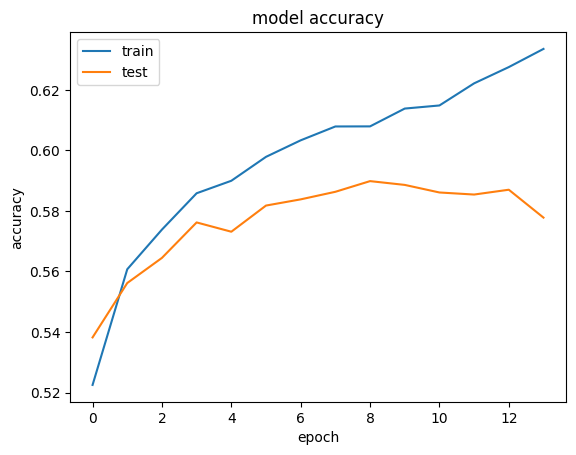

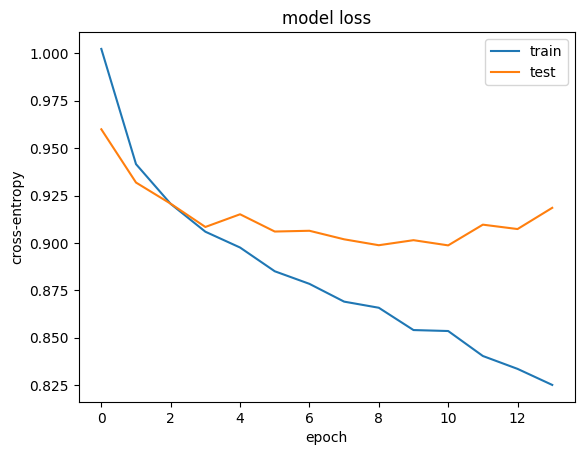

In [75]:

import keras
from keras.models import Sequential
from keras.layers import Embedding, Dropout, Reshape, MaxPooling2D, Flatten, Dense, Add
from keras.optimizers import Adam
from tensorflow.keras import layers

keras.backend.clear_session()

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=X.shape[1],
                    trainable=False))

# First BiLSTM Layer with Attention
x = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(model.output)
query_value_attention_seq = layers.Attention()([x, x])
x = layers.Add()([x, query_value_attention_seq])
x = layers.Dropout(0.5)(x)

# Second BiLSTM Layer with Attention
x = layers.Bidirectional(layers.LSTM(units=128, return_sequences=True))(x)
query_value_attention_seq = layers.Attention()([x, x])
x = layers.Add()([x, query_value_attention_seq])
x = layers.Dropout(0.5)(x)


# # Flatten the pooled output
x = layers.Flatten()(x)

# Dense Layer for Classification
output = layers.Dense(3, activation='softmax')(x)

# Final model assembly
final_model = keras.Model(inputs=model.input, outputs=output)

optimizer = Adam(lr=0.001)

# Compile and test model
final_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
history = final_model.fit(X_train, Y_train, epochs=50, batch_size=512, validation_data=(X_test, Y_test), callbacks=callbacks_list)


#Plotting the training accuracies
plt.figure(1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('LSTM-Bidirectional-Final-Accuracy.png')

#Plotting the losses
plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('cross-entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('LSTM-Bidirectional-Final-Loss.png')

In [77]:
model.save('models/BiLSTM_ternary')

INFO:tensorflow:Assets written to: models/BiLSTM_ternary/assets


INFO:tensorflow:Assets written to: models/BiLSTM_ternary/assets


In [78]:
# To print the final training accuracy
final_train_accuracy = history.history['categorical_accuracy'][-1]
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")

# To print the final validation (test) accuracy
final_val_accuracy = history.history['val_categorical_accuracy'][-1]
print(f"Final Validation (Test) Accuracy: {final_val_accuracy:.4f}")


Final Training Accuracy: 0.6335
Final Validation (Test) Accuracy: 0.5778


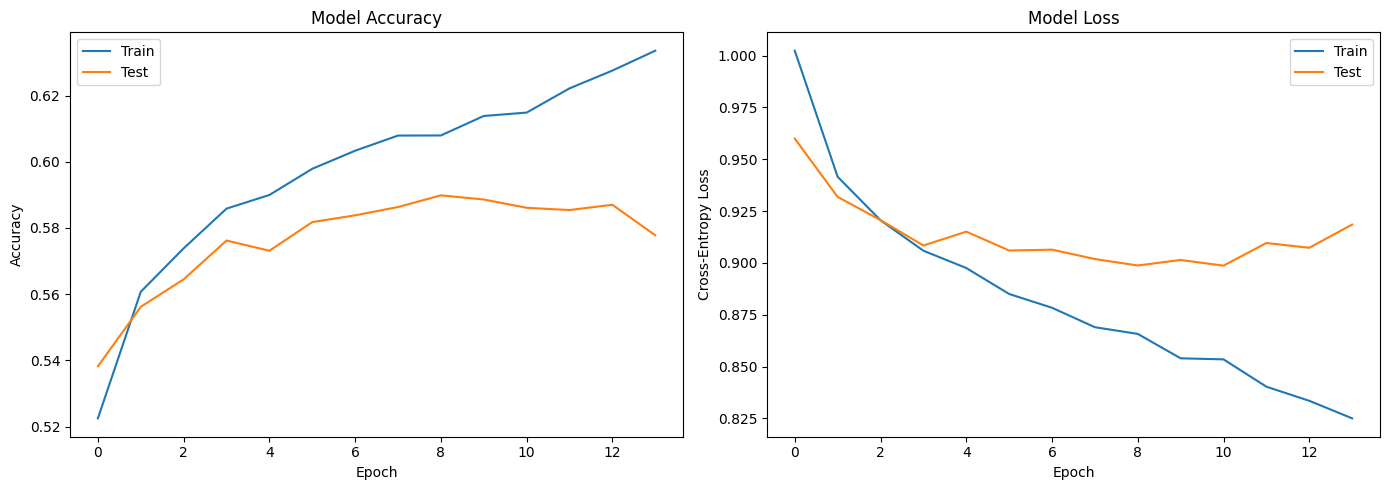

In [79]:
#plotting accuracy & loss
plt.figure(figsize=(14, 5)) 


plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train')
plt.plot(history.history['val_categorical_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.ylabel('Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout() 
plt.show()

